# Custom composite LRP on ImageNet
In this notebook we show how to define custom composite LRP analyzers in **iNNvestigate** to analyze the prediction of ImageNet models. To do so we will load a network from the keras.applications module.

Parts of the code that do not contribute to the main focus are outsourced into utility modules. To learn more about the basic usage of iNNvestigate have look into this notebook: [Introduction to iNNvestigate](introduction.ipynb) and [Comparing methods on MNIST](mnist_method_comparison.ipynb)

**If you are already familiar with iNNvestigate, you can skip ahead to the [Analysis section](#Analysis-with-composite-LRP).**

## Preparation
**To use this notebook please download the example images using the following script:**

`innvestigate/examples/images/wget_imagenet_2011_samples.sh`

To show you hands-on how to use **iNNvestigate** we now import all needed modules and load a VGG16 model:

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
%matplotlib inline  

import imp
import numpy as np
import matplotlib.pyplot as plot
import os

import keras
import keras.backend
import keras.layers
import keras.models

import innvestigate
import innvestigate.applications.imagenet
import innvestigate.utils as iutils

# Use utility libraries to focus on relevant iNNvestigate routines.
eutils = imp.load_source("utils", "../utils.py")
imgnetutils = imp.load_source("utils_imagenet", "../utils_imagenet.py")

Using TensorFlow backend.


### Model
In this demo use the VGG16-model, which uses ReLU activation layers.

In [3]:
# Load the model definition.
tmp = getattr(innvestigate.applications.imagenet, os.environ.get("NETWORKNAME", "vgg16"))
net = tmp(load_weights=True, load_patterns="relu")

# Build the model.
model = keras.models.Model(inputs=net["in"], outputs=net["sm_out"])
model.compile(optimizer="adam", loss="categorical_crossentropy")

# Handle input depending on model and backend.
channels_first = keras.backend.image_data_format() == "channels_first"
if channels_first:
    channel_axis = 1
else:
    channel_axis = 3
color_conversion = "BGRtoRGB" if net["color_coding"] == "BGR" else None

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



We want to analyze the pre-softmax activations:

In [4]:
# Create model without trailing softmax
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model)

### Data
Finally, we load a sample image and preprocess it to fit the model input size.

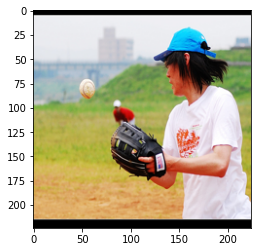

In [5]:
# Get some example test set images.
images, label_to_class_name = eutils.get_imagenet_data(net["image_shape"][0])

if not len(images):
    raise Exception("Please download the example images using: "
                    "'innvestigate/examples/images/wget_imagenet_2011_samples.sh'")

# Choose a sample image and add batch axis
image = images[0][0][None, :, :, :]
# Preprocess it for VGG16
x = imgnetutils.preprocess(image, net)
# Displaying the image
plot.imshow(image[0]/255)
plot.show()

## Analysis with composite LRP
We can define a custom composite LRP analyzer using iNNvestigate's `LRP` class and the keyword arguments
* `rule`: general rule applied to the layers
* `input_layer_rule`: rule applied to the input layer
* `until_layer_rule` (with `until_layer_index`): rule applied to the first layers up to `until_layer_index` 
* `bn_layer_rule`: rule applied to (fused) batch-norm layers

For each of these arguments, a rule can be selected by passing its name. Usable rules are summarized [in this dictionary](https://github.com/albermax/innvestigate/blob/c6ce89323d686a52d793177efd8d1dda3bd9526a/src/innvestigate/analyzer/relevance_based/relevance_analyzer.py#L161-L177).

### Example
Let's create an analyzer that uses the LRP-0 zero rule but applies LRP-$z^\mathcal{B}$ to the input layer and LRP-$\gamma$ to the first 5 layers:

In [6]:

from innvestigate.analyzer import LRP

analyzer = LRP(
    model_wo_softmax, 
    rule="Z",
    input_layer_rule="Bounded", 
    until_layer_idx=5, 
    until_layer_rule="Gamma", 
    bn_layer_rule="Z"
)

and apply it to our VGG16 model:

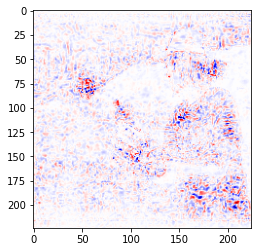

In [7]:
a = analyzer.analyze(x)

# Postprocess
a = imgnetutils.postprocess(a, color_conversion, channels_first)
# Displaying the gradient
plot.imshow(imgnetutils.heatmap(a)[0])
plot.show()

## References
For more information on composite LRP, refer to the following papers:

1. Lapuschkin, S., Binder, A., Muller, K. R., & Samek, W. (2017). [Understanding and Comparing Deep Neural Networks for Age and Gender Classification](https://arxiv.org/abs/1708.07689), Proceedings of the IEEE International Conference on Computer Vision Workshops. 2017.
1. Kohlbrenner, M., Bauer, A., Nakajima, S., Binder, A., Samek, W., & Lapuschkin, S. (2020). [Towards Best Practice in Explaining Neural Network Decisions with LRP](https://ieeexplore.ieee.org/abstract/document/9206975), 2020 International Joint Conference on Neural Networks (IJCNN), 2020, pp. 1-7, doi: 10.1109/IJCNN48605.2020.9206975.
1. Montavon, G., Binder, A., Lapuschkin, S., Samek, W., & Müller, K. R. (2019). [Layer-wise relevance propagation: an overview](https://link.springer.com/chapter/10.1007/978-3-030-28954-6_10), Explainable AI: interpreting, explaining and visualizing deep learning, 193-209.